In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from rrsklearn import RRRandomForestClassifier
from rrsklearn import RRDecisionTreeClassifier
from rrsklearn import RRGradientBoostingClassifier
from rrsklearn import RandomRotation
sns.set()

In [2]:
def plot_comparison(datasets, classifiers, filename, h=0.01):
    figure = plt.figure(figsize=(3*(len(classifiers)+1), 9))
    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=.4, random_state=42)

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data")
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
                   edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in classifiers.items():
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                       edgecolors='k')
            # Plot the testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       edgecolors='k', alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right')
            i += 1

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

In [3]:
rng = np.random.RandomState(5)
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=rng)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

In [4]:
datasets = [
    make_moons(noise=0.3, random_state=rng),
    make_circles(noise=0.2, factor=0.5, random_state=rng),
    linearly_separable
]

In [5]:
forests = {
    'Random Forest': RandomForestClassifier(
        max_depth=4, n_estimators=200, max_features=1, random_state=rng
    ),
    'Random Rotation Random Forest': RRRandomForestClassifier(
        max_depth=4, n_estimators=200, max_features=1, random_state=rng
    )
}

boostings = {
    'Gradient Boosting Machine': GradientBoostingClassifier(
        max_depth=4, n_estimators=200, max_features=1, random_state=rng
    ),
    'Rotation Ensemble GBM': VotingClassifier([(f'gbm{i}', make_pipeline(
        RandomRotation(),
        GradientBoostingClassifier(max_depth=4, n_estimators=5, max_features=1)
    )) for i in range(40)], voting='soft'),
    'Random Rotation GBM': RRGradientBoostingClassifier(
        max_depth=4, n_estimators=200, max_features=1, random_state=rng
    )
}

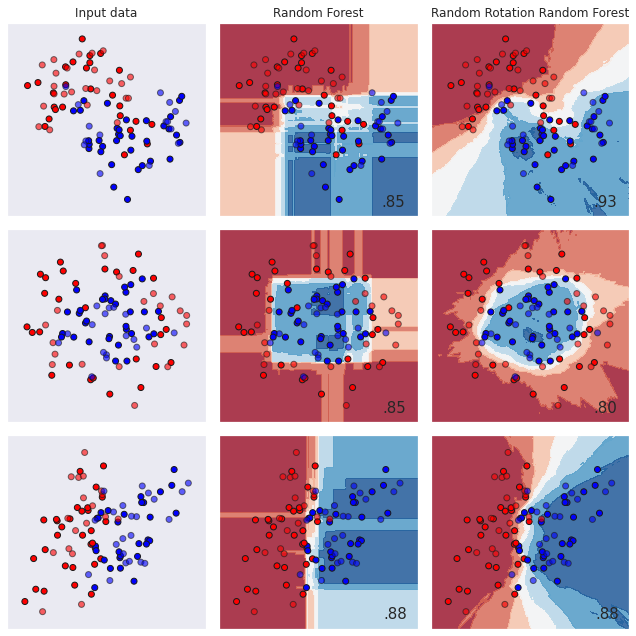

In [6]:
plot_comparison(datasets, forests, 'forests.png', h=0.02)

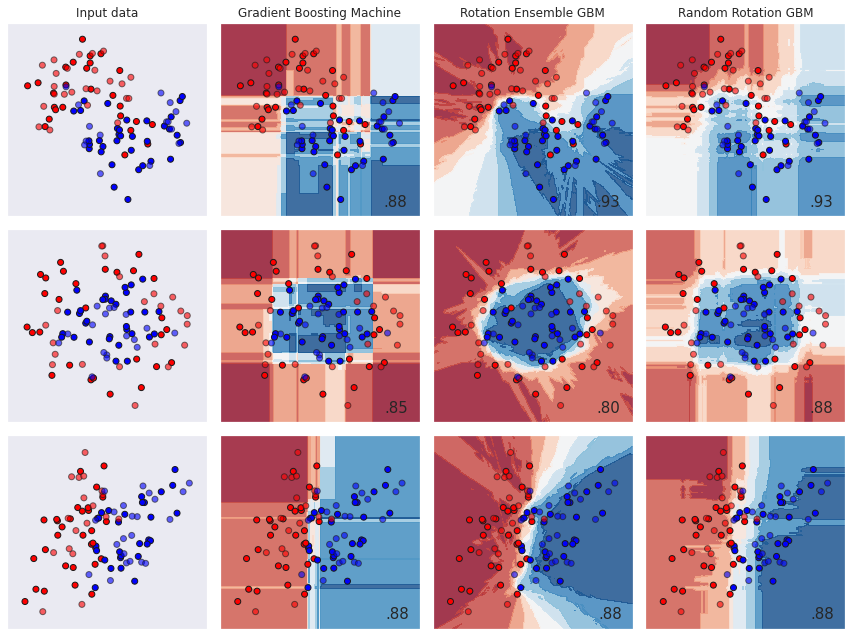

In [8]:
plot_comparison(datasets, boostings, 'boostings.png', h=0.01)